In [8]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
            
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

In [ ]:
PARA_DIR = "/home/alvin/Documents/malaria-detection/cell_images/cell_images/Parasitized/"
UNIF_DIR =  "c/home/alvin/Documents/malaria-detection/cell_images/cell_images/Uninfected/"

In [ ]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

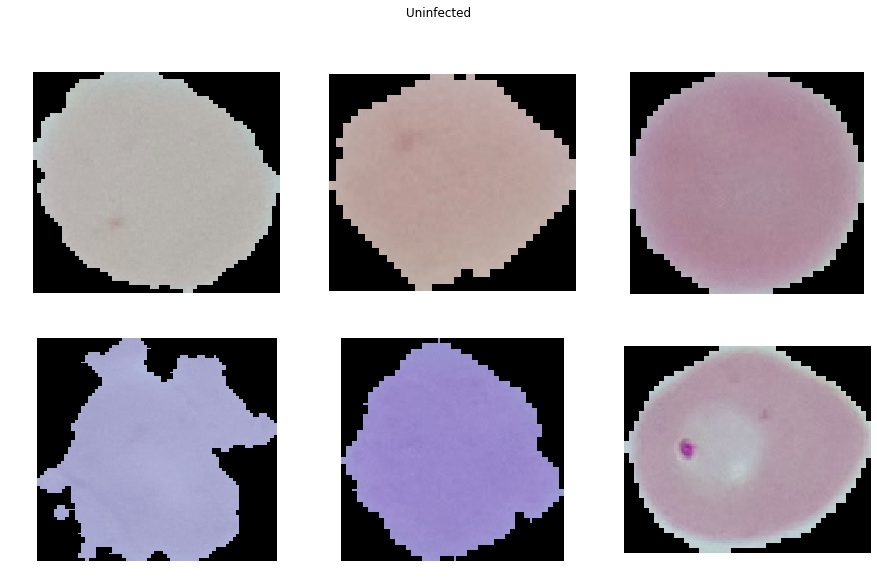

In [9]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

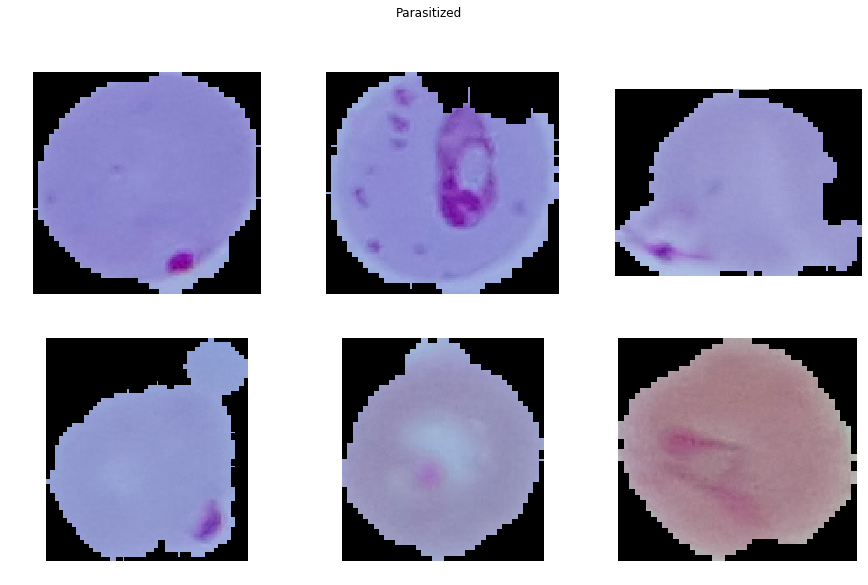

In [10]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('cell_images/Parasitized/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [11]:
data=[]
labels=[]
Parasitized=os.listdir("cell_images/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("cell_images/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [ ]:
Cells=np.array(data)
labels=np.array(labels)

In [ ]:
np.save("Cells",Cells)
np.save("labels",labels)

In [ ]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [ ]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

In [ ]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [ ]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed
np.random.seed(0)

In [21]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         


In [22]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [24]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
h=model.fit(x_train,y_train,batch_size=32,callbacks=callbacks, validation_data=(x_test,y_test),epochs=20,verbose=1)

Train on 24803 samples, validate on 2755 samples
Epoch 1/20
24803/24803 [==============================] - 16s 634us/step - loss: 0.3904 - acc: 0.8049 - val_loss: 0.1509 - val_acc: 0.9546
Epoch 2/20
24803/24803 [==============================] - 9s 381us/step - loss: 0.1755 - acc: 0.9445 - val_loss: 0.1406 - val_acc: 0.9564
Epoch 3/20
24803/24803 [==============================] - 9s 370us/step - loss: 0.1624 - acc: 0.9496 - val_loss: 0.1399 - val_acc: 0.9583
Epoch 4/20
24803/24803 [==============================] - 9s 371us/step - loss: 0.1523 - acc: 0.9527 - val_loss: 0.1277 - val_acc: 0.9608
Epoch 5/20
24803/24803 [==============================] - 9s 373us/step - loss: 0.1449 - acc: 0.9541 - val_loss: 0.1196 - val_acc: 0.9626
Epoch 6/20
24803/24803 [==============================] - 9s 370us/step - loss: 0.1418 - acc: 0.9541 - val_loss: 0.1172 - val_acc: 0.9633
Epoch 7/20
24803/24803 [==============================] - 9s 373us/step - loss: 0.1361 - acc: 0.9554 - val_loss: 0.1130 - 

In [ ]:
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

In [ ]:
score=model.evaluate(x_test,y_test)
print(score)

2755/2755 [==============================] - 0s 127us/step
[0.1328830818349864, 0.9586206896551724]


In [ ]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

2755/2755 [==============================] - 0s 87us/step

 Test_Accuracy:- 0.9586206896551724


In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

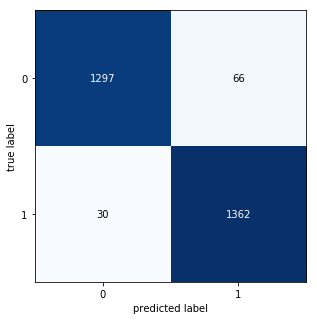

In [26]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
i=9
pred = model.predict(x_test,batch_size=1)
pred = np.argmax(pred,axis = 1)

In [42]:
pred[0]

1

In [ ]:
model.save('my_model.h5')

In [ ]:
len(model.layers)

13

In [ ]:
x_test.shape[0]

2755

In [ ]:
import keras
print(keras.__version__)

2.2.5


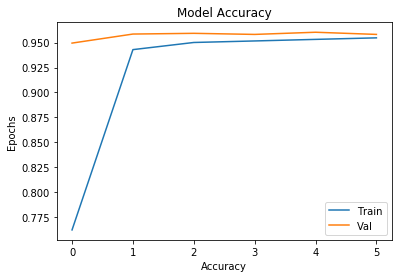

In [ ]:
plt.plot(h.history['acc'])
plt.plot(h.history["val_acc"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
fpr_keras, tpr_keras, thresholds = roc_curve(y_true.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9584655556822357

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

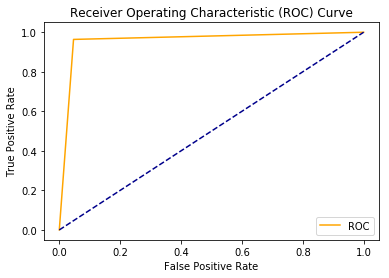

In [ ]:
plot_roc_curve(fpr_keras, tpr_keras)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:


print('{}'.format( 
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1432
           1       0.95      0.96      0.96      1323

    accuracy                           0.96      2755
   macro avg       0.96      0.96      0.96      2755
weighted avg       0.96      0.96      0.96      2755



In [ ]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
malaria_labels = ['Parasitized','Uninfected']

In [ ]:
x_test.shape[0]

2755

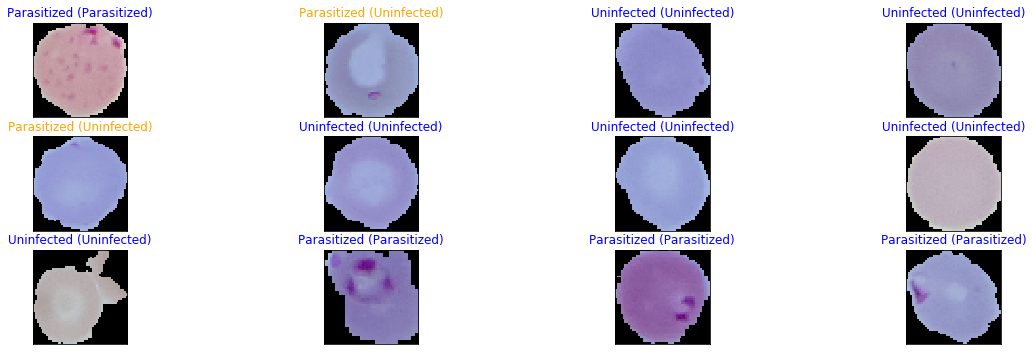

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(malaria_labels[pred_idx], malaria_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))